<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project1/Cp2/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises: physics-informed neural network

Exercise on the implementation of physics-informed neural network.

Date: 2024

Course: 056936 - SCIENTIFIC COMPUTING TOOLS FOR ADVANCED MATHEMATICAL MODELLING (PAGANI STEFANO) [2023-24].

Example adapted from this [notebook](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link).


Let us consider the problem

\begin{aligned}
  & v_f *\sqrt(\nabla u\cdot D\nabla u) =1  \,, \quad (x,y) \in [-1.5,1.5] \times [-1.5,1.5]\,\\
\end{aligned}

where $\nu$ is unknown. We consider the PINN framework for solving the state/parameter estimation.

In [1]:
# import required libraries

import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling

  Preparing metadata (setup.py) ... done


In [2]:
# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp2

Cloning into 'ScientificTools'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 384 (delta 68), reused 1 (delta 1), pack-reused 156
Receiving objects: 100% (384/384), 99.95 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (106/106), done.
/content/ScientificTools/Project1/Cp2


In [4]:
# loading of the dataset

CP2data = np.load("CP2data.npz")
CP2data = CP2data['arr_0']

In [5]:
# loading of the estimate

CP2estimate = np.load("CP2estimate.npz")
CP2estimate = CP2estimate['arr_0']

In [6]:
CP2estimate[4]

array([0.1226488 , 3.6316356 , 0.84714825])

# Solution

In [7]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],Y.flatten()[:,None])),dtype=tf.float64)
x0 = 1.5
#activation_time = anysotropic_FMM( x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22 )

In [63]:
def penalty(param, lower_bound, upper_bound):
    return tf.reduce_sum(tf.square(tf.maximum(param - upper_bound, 0)) +
                         tf.square(tf.maximum(lower_bound - param, 0)))
# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,param):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,param)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    # bc
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), param[2] ] ) ) ) ,2)

    #penalty over param boundaries
    mse_penalty=penalty(param[0],-np.pi/10,np.pi/10)+penalty(param[1],1,9)+penalty(param[2],-1.5,1.5)

    return mse_r + mse_meas + mse_bc + mse_penalty
    #tf.print('mse_time',mse_meas)
    #tf.print('mse_param',mse_r)
    #tf.print('mse_bc',mse_bc)

# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,param):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,param)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grad_param = tape.gradient(loss_value,param)
    return loss_value, grads, grad_param

In [64]:
from sklearn.model_selection import train_test_split
# collocation points
Ncl = 10000
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

# measurement points
ind_disp=4
xmeas = CP2data[ind_disp][0]
ymeas = CP2data[ind_disp][1]
tmeas = CP2data[ind_disp][2]
xmeas_train, xmeas_val, ymeas_train, ymeas_val, tmeas_train, tmeas_val = train_test_split(xmeas, ymeas, tmeas, test_size=0.1)
xmeas_train = tf.constant(xmeas_train.reshape(18, 1), dtype=tf.float64)
ymeas_train = tf.constant(ymeas_train.reshape(18, 1), dtype=tf.float64)
tmeas_train = tf.constant(tmeas_train.reshape(18, 1), dtype=tf.float64)
xmeas_val = tf.constant(xmeas_val.reshape(2, 1), dtype=tf.float64)
ymeas_val = tf.constant(ymeas_val.reshape(2, 1), dtype=tf.float64)
tmeas_val = tf.constant(tmeas_val.reshape(2, 1), dtype=tf.float64)




In [72]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM


regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    tf.keras.layers.Reshape((1, 32)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])


In [ ]:
# residual computation based on AD
@tf.function
def r_PINN(x,y,param):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    theta0 = pi/2 - param[0]
    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D = ((1/param[1])* tf.linalg.matmul(a,tf.transpose(a)) + tf.linalg.matmul(b,tf.transpose(b)))

    #return  tf.linalg.matmul(tf.transpose(u_grad), tf.linalg.matmul(D,u_grad)) - 1/100**2
    return tf.sqrt((u_x * D[0,0] * u_x + u_x * D[0,1] * u_y + u_y * D[1,0] * u_x + u_y * D[1,1] * u_y))  - 1/100

# Adam optimizer
initial_learning_rate=0.005

tf_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate,beta_1=0.99)

# parameter variable try ( 1.45816415][ 3.84494007][-0.95064015]])
#param 0 -> fiber anlge (-pi/10,pi/10)
#param 1-> aniso (0,1)
#param 2-> source y0 (-1.5,1,5)
pi = tf.constant(np.pi,dtype=tf.float64)
param = tf.Variable([[0.01], [3], [0.1]], trainable=True,dtype=tf.float64)

patience = 600
patience_lr= 500
min_delta = 1e-9
best_val_loss = float('inf')
wait = 0

for iter in range(20000):

  # compute gradients using AD
  loss_value,grads,grad_param = grad(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train, param)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads+[grad_param],PINN.trainable_variables+[param]))

  val_loss, _, _ = grad(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val, param)



  # Early stopping
  if val_loss < best_val_loss - min_delta:
      best_val_loss = val_loss
      wait = 0
  else:
      wait += 1
      if wait >= patience_lr:
         tf_optimizer.learning_rate = tf_optimizer.learning_rate*0.8

      if wait >= patience:
          print('Early stopping at epoch', iter + 1)
          break

  # display intermediate results
  if ((iter+1) % 100 == 0):
    print('iter =  '+str(iter+1))
    #loss_value_np=loss_value.numpy()
    #print('loss = {:.4f}'.format(loss_value_np ))
    tf.print('loss =' , loss_value)
    tf.print('loss_val =' , val_loss)

    print(param.numpy())
    PINN_flat = PINN(X_flat)
    """
    mse = 0.0
    time_pred = tf.reshape(PINN_flat, (151, 151))
    time_pred = time_pred.numpy()
    xmeas=xmeas.numpy().squeeze()
    ymeas=ymeas.numpy().squeeze()
    tmeas=tmeas.numpy().squeeze()

    for k in range(20):
            i, j = np.where((X == xmeas[k]) & (Y == ymeas[k]))
            mse+= (time_pred[i, j] - tmeas[k]) ** 2

    print('mse error: %.4e' % (np.sqrt(mse/20)))

    xmeas = tf.constant(xmeas.reshape(20, 1), dtype=tf.float64)
    ymeas = tf.constant(ymeas.reshape(20, 1), dtype=tf.float64)
    tmeas = tf.constant(tmeas.reshape(20, 1), dtype=tf.float64)
    """

iter =  100
loss = [[6.5385566865620523e-05]]
loss_val = [[9.5325699187269632e-05]]
[[0.30292511]
 [3.26353957]
 [0.04400609]]
iter =  200
loss = [[2.6796578513976597e-05]]
loss_val = [[1.2405077182948235e-05]]
[[0.28185914]
 [3.45662794]
 [0.11248866]]
iter =  300
loss = [[1.2606561218193836e-05]]
loss_val = [[6.2965424862262873e-06]]
[[0.29389693]
 [3.62195096]
 [0.22322437]]
iter =  400
loss = [[6.1434539642617035e-06]]
loss_val = [[4.3172412713581258e-06]]
[[0.30808596]
 [3.74735283]
 [0.34022108]]
iter =  500
loss = [[2.9736028600931512e-06]]
loss_val = [[3.8183291312274989e-06]]
[[0.31293313]
 [3.83409981]
 [0.43278882]]
iter =  600
loss = [[1.9593366839652828e-06]]
loss_val = [[2.6735805764654628e-06]]
[[0.30828836]
 [3.90436903]
 [0.49644427]]
iter =  700
loss = [[1.4132582930239459e-06]]
loss_val = [[1.9125854219784472e-06]]
[[0.30484359]
 [3.942165  ]
 [0.54034327]]
iter =  800
loss = [[1.2184174509567905e-06]]
loss_val = [[1.6026848536150282e-06]]
[[0.30278309]
 [3.94994398]

In [29]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution(x, y, t, X, Y, s_value=0.05, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(151,151)

    return time_pred

In [30]:
time_pred=checkpoint1_solution(xmeas, ymeas, tmeas, X, Y, s_value=0.05, s_aniso_1=0.5, s_aniso_2=0.5)

In [36]:
mse=0.0
PINN_flat = PINN(X_flat)
time_pred_net = tf.reshape(PINN_flat, (151, 151))

for i in range(151):
  for j in range(151):
    mse += (time_pred[i, j] - time_pred_net[i,j]) ** 2

mse_sq= np.sqrt(mse/22801)

print(np.mean(mse_sq))

0.0024212046071891147


<Figure size 640x480 with 0 Axes>

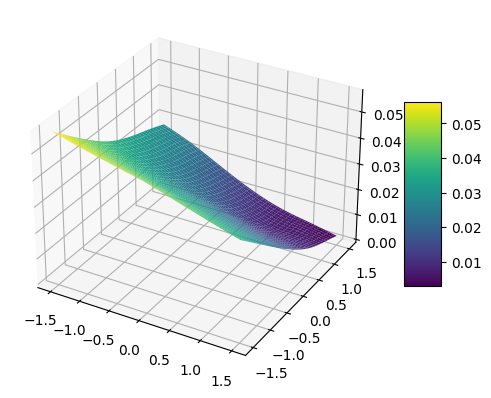

In [37]:
plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,time_pred, cmap = 'viridis')
ax.axes.set_zlim3d(bottom=0, top=np.max(time_pred))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

<Figure size 640x480 with 0 Axes>

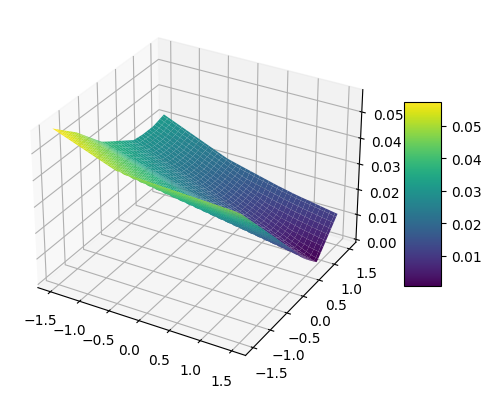

In [38]:
plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,time_pred_net, cmap = 'viridis')
ax.axes.set_zlim3d(bottom=0, top=np.max(time_pred))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

In [40]:
np.where(time_pred_net==np.min(time_pred_net))

(array([118]), array([150]))

In [42]:
Y[118,]

array([0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86,
       0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.

In [ ]:
#Display results

N_h = 150
X_plot, Y_plot = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
plt.scatter(xmeas,ymeas,marker='x',s=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
plt.scatter(xmeas,ymeas,marker='x',s=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)